In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-csv/data.csv


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

Number of samples: 5025
FULL Dataset: 5025
TRAIN Dataset: 4020
TEST Dataset: 1005


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cost at epoch 0 is 3.52128
Cost at epoch 1 is 2.94857
Cost at epoch 2 is 2.33797
Cost at epoch 3 is 1.84456
Cost at epoch 4 is 1.45487
Cost at epoch 5 is 1.16083
Cost at epoch 6 is 0.92168
Cost at epoch 7 is 0.73008
Cost at epoch 8 is 0.59048
Cost at epoch 9 is 0.46286
Cost at epoch 10 is 0.37868
Cost at epoch 11 is 0.31422
Cost at epoch 12 is 0.27026
Cost at epoch 13 is 0.21821
Cost at epoch 14 is 0.19131
Cost at epoch 15 is 0.15565
Cost at epoch 16 is 0.13350
Cost at epoch 17 is 0.11468
Cost at epoch 18 is 0.10423
Cost at epoch 19 is 0.09402
Got 883 / 1005 with accuracy 87.86
Number of unique classes in the data: 45
              precision    recall  f1-score   support

   T1003.001       0.91      1.00      0.95        21
       T1005       0.58      0.54      0.56        13
       T1012       1.00      0.20      0.33         5
       T1016       1.00      0.82      0.90        11
   T1021.001       0.86      1.00      0.93        19
       T1027       0.89      0.91      0.90      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


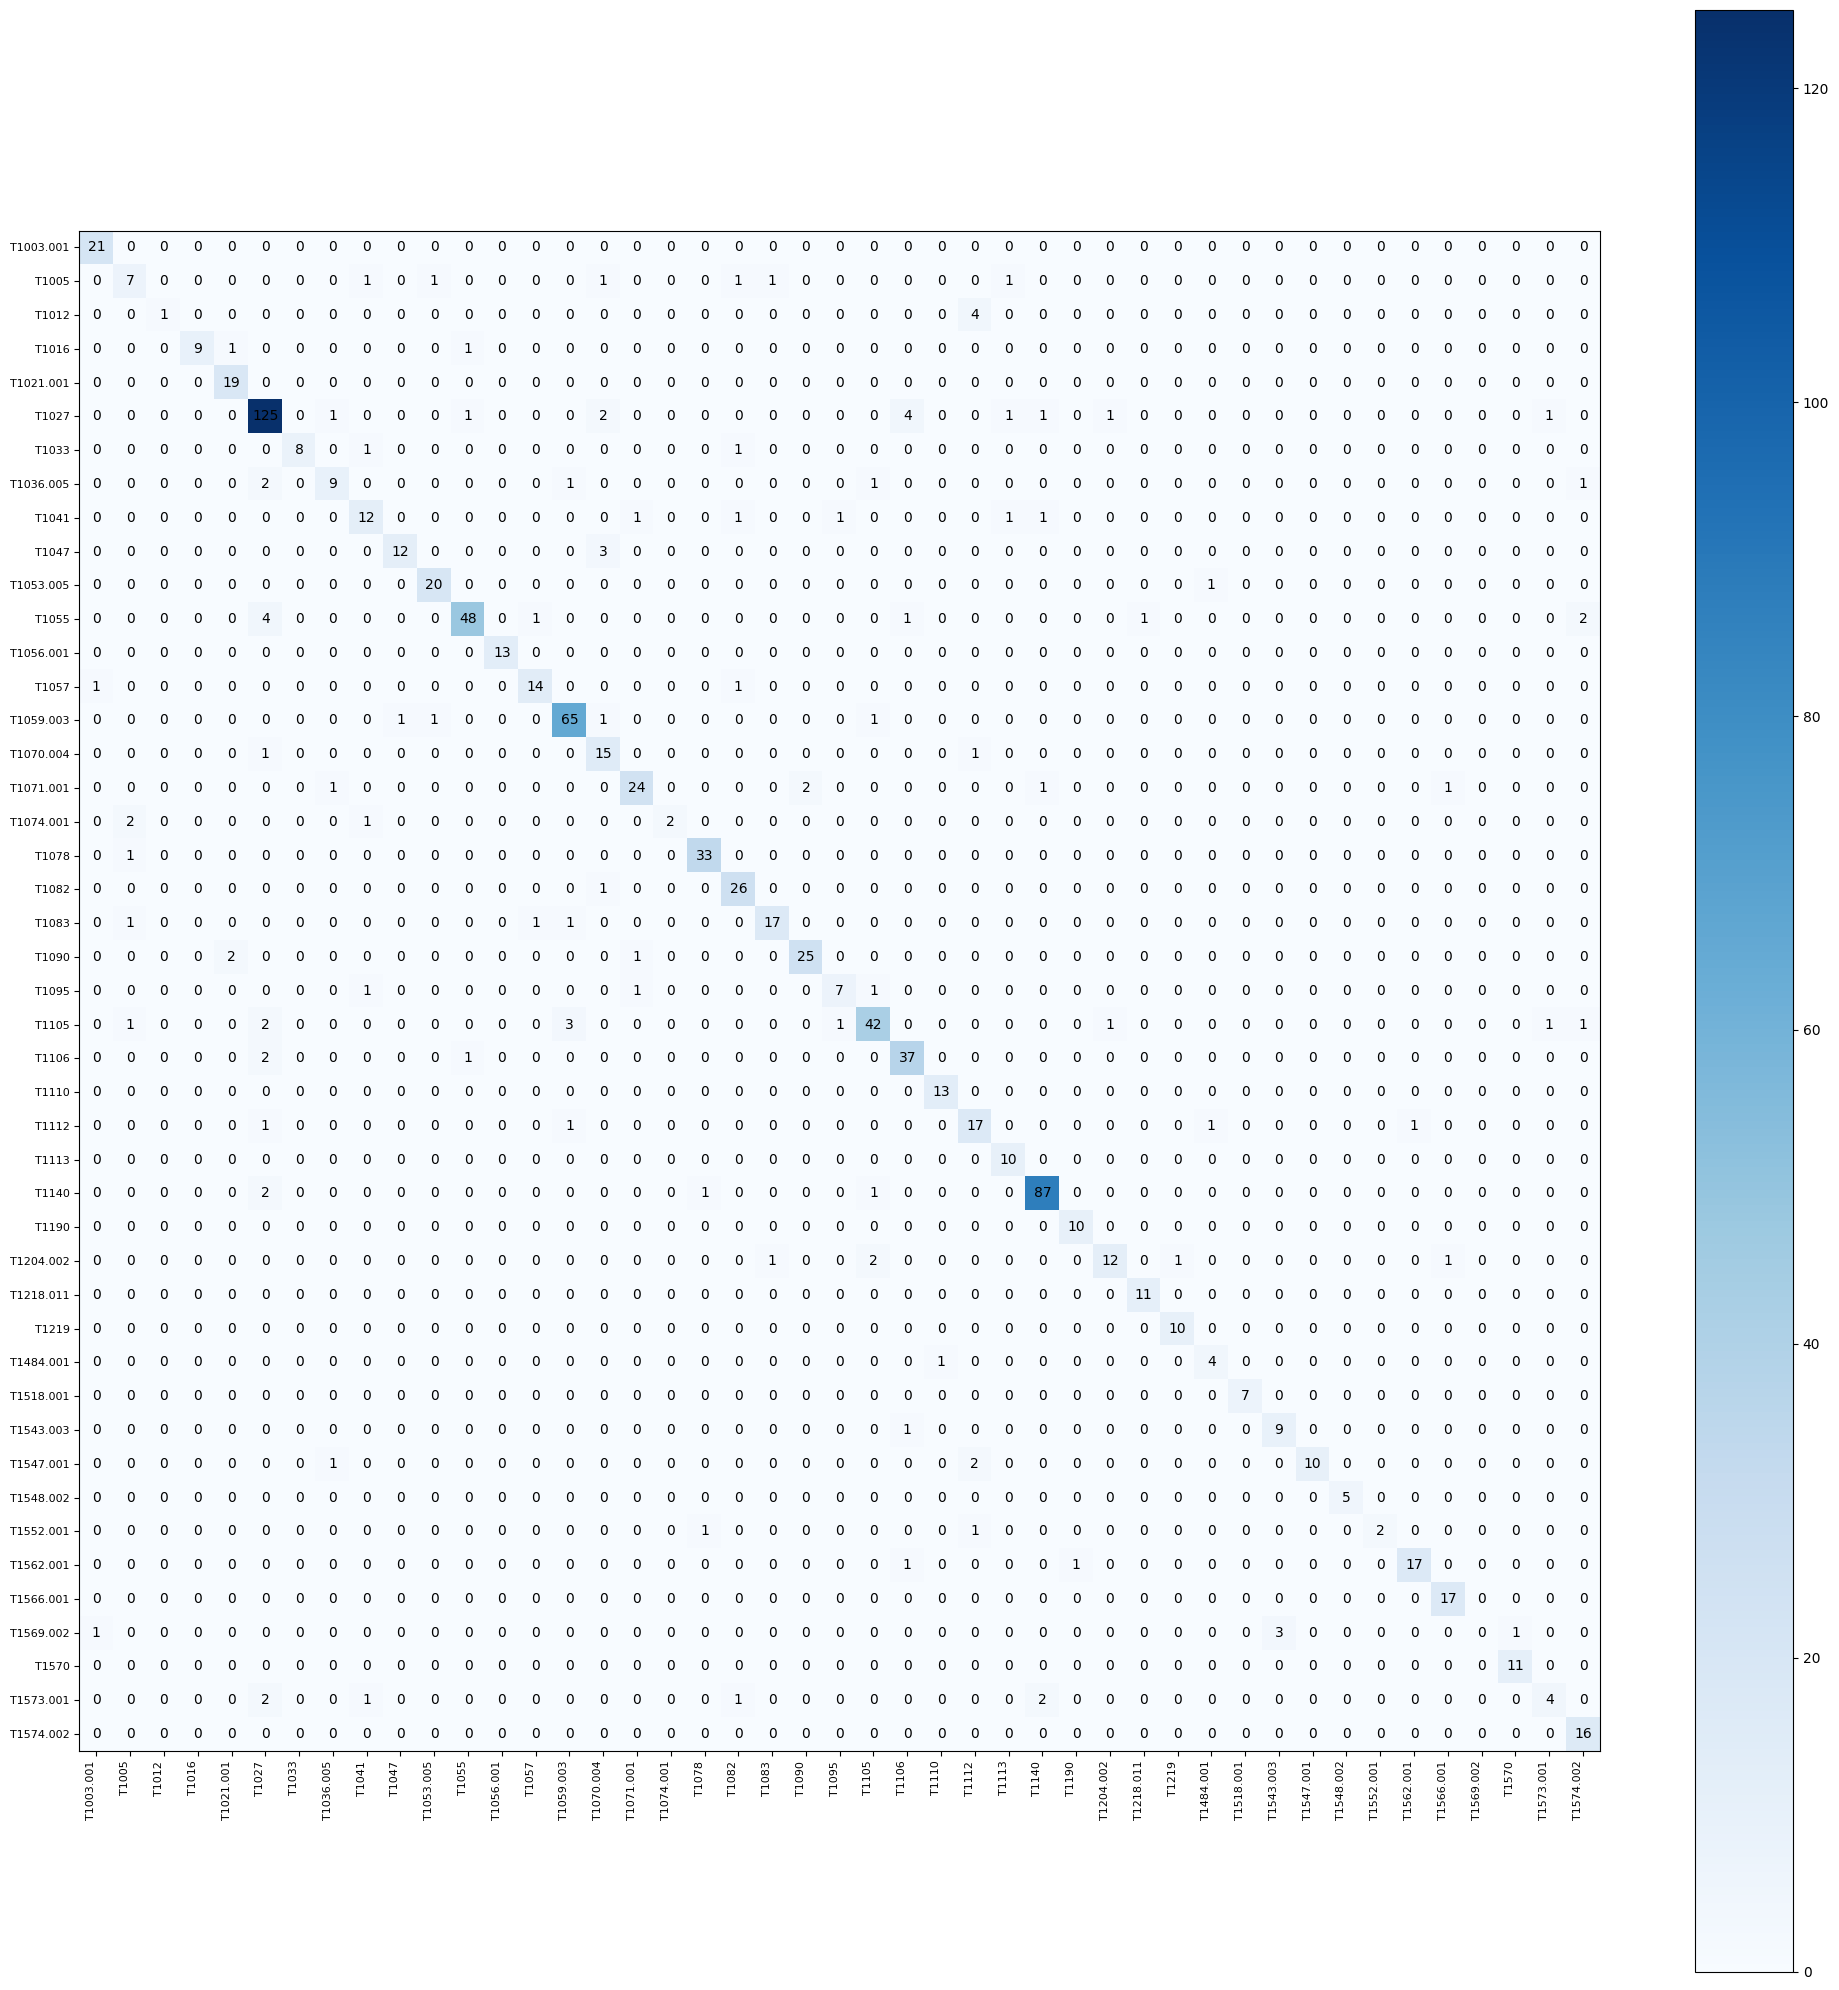

--- 1527.409234046936 seconds ---


In [4]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertConfig, AutoModel
from sklearn.preprocessing import LabelEncoder
import time
from time import sleep
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import csv
import os

# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
pretrained_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)

# Load data using csv module
def load_data(filename):
    texts = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        csv_reader = csv.reader(f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            if len(row) >= 2:
                texts.append(row[0])
                labels.append(row[1])
    return np.array(texts), np.array(labels)

# Load data
# Update the path to match Kaggle's file structure
data_path = '/kaggle/input/data-csv/data.csv'
texts, labels = load_data(data_path)
print("Number of samples:", len(texts))

LABELS = len(np.unique(labels))

def experiment(seed):
    start_time = time.time()
    
    # Load data for each experiment
    texts, labels = load_data(data_path)

    LABELS = len(np.unique(labels))

    # Encoding labels
    encoder = LabelEncoder()
    encoder.fit(labels)
    enc_domain = encoder.transform(labels)

    # Create a dictionary to map encoded labels back to original labels
    label_map = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

    # Defining some key variables that will be used later on in the training
    MAX_LEN = 128
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 1e-05

    class Triage(Dataset):
        def __init__(self, text, labels, tokenizer, max_len):
            self.len = len(text)
            self.text = text
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __getitem__(self, index):
            sentence = str(self.text[index])
            sentence = " ".join(sentence.split())
            inputs = self.tokenizer.encode_plus(
                sentence,
                None,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                return_token_type_ids=True,
                truncation=True
            )
            ids = inputs['input_ids']
            mask = inputs['attention_mask']

            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.labels[index], dtype=torch.long)
            }

        def __len__(self):
            return self.len

    experiment_seed = seed
    # Split dataset into train and validation
    indices = np.arange(len(enc_domain))
    train_indices, test_indices = train_test_split(indices, random_state=seed, test_size=0.2, stratify=enc_domain)

    train_text = texts[train_indices]
    train_labels = enc_domain[train_indices]
    test_text = texts[test_indices]
    test_labels = enc_domain[test_indices]

    print("FULL Dataset: {}".format(len(texts)))
    print("TRAIN Dataset: {}".format(len(train_text)))
    print("TEST Dataset: {}".format(len(test_text)))

    training_set = Triage(train_text, train_labels, tokenizer, MAX_LEN)
    testing_set = Triage(test_text, test_labels, tokenizer, MAX_LEN)

    train_params = {'batch_size': BATCH_SIZE,
                    'shuffle': True,
                    'num_workers': 0
                    }

    test_params = {'batch_size': BATCH_SIZE,
                   'shuffle': True,
                   'num_workers': 0
                   }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)

    class BERTClass(torch.nn.Module):
        def __init__(self, pretrained_model_name: str, num_classes: int = None, dropout: float = 0.5):
            super().__init__()
            config = BertConfig.from_pretrained(pretrained_model_name, output_hidden_states=True)
            self.model = AutoModelForMaskedLM.from_pretrained(pretrained_model_name, config=config).base_model
            self.pre_classifier = torch.nn.Linear(768, 768)
            self.dropout = torch.nn.Dropout(dropout)
            self.classifier = torch.nn.Linear(768, num_classes)

        def forward(self, input_ids, attention_mask):
            output_1 = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_state = output_1[0]
            pooler = hidden_state[:, 0]
            pooler = self.pre_classifier(pooler)
            pooler = torch.nn.ReLU()(pooler)
            pooler = self.dropout(pooler)
            output = self.classifier(pooler)
            return output

    model = BERTClass("bert-base-uncased", LABELS)
    model.to(device)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

    def calculate_accu(big_idx, targets):
        n_correct = (big_idx == targets).sum().item()
        return n_correct

    torch.cuda.empty_cache()

    def train(epoch):
        tr_loss = 0
        n_correct = 0
        nb_tr_steps = 0
        examples = len(train_text)
        losses = [None] * len(training_loader)
        model.train()
        for i, data in enumerate(training_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)

            losses[i] = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")
        return

    for epoch in range(EPOCHS):
        train(epoch)

    def check_accuracy(loader, model):
        num_correct = 0
        num_samples = 0
        model.eval()
        pred = []
        y_test = []

        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                x = data['ids'].to(device, dtype=torch.long)
                mask = data['mask'].to(device, dtype=torch.long)
                y = data['targets'].to(device, dtype=torch.long)

                scores = model(x, mask)
                _, predictions = scores.max(1)
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)
                pred.append(predictions.cpu().numpy())
                y_test.append(y.cpu().numpy())

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        return pred, y_test

    pred, y_test = check_accuracy(testing_loader, model)

    y_pred = np.concatenate(pred)
    y = np.concatenate(y_test)

    print(f"Number of unique classes in the data: {len(np.unique(y))}")

    # Use the label_map to get original label names
    original_labels = [label_map[i] for i in range(len(np.unique(y)))]

    print(classification_report(y, y_pred, target_names=original_labels))

    report = classification_report(y, y_pred, target_names=original_labels, digits=4, output_dict=True, zero_division=0)

    f1_weighted = report['weighted avg']['f1-score']
    recall_weighted = report['weighted avg']['recall']
    precision_weighted = report['weighted avg']['precision']
    accuracy = accuracy_score(y, y_pred)
    f1_macro = report['macro avg']['f1-score']
    recall_macro = report['macro avg']['recall']
    precision_macro = report['macro avg']['precision']

    print("Weighted Precision:", precision_weighted)
    print("Weighted Recall:", recall_weighted)
    print("Weighted F1 Score:", f1_weighted)
    print("Macro Precision:", precision_macro)
    print("Macro Recall:", recall_macro)
    print("Macro F1 Score:", f1_macro)
    print("Accuracy: ", accuracy)

    # Updated confusion matrix visualization
    fig, ax = plt.subplots(figsize=(20, 20))  # Increased figure size
    cm_array = confusion_matrix(y, y_pred)
    im = ax.imshow(cm_array, cmap='Blues')
    ax.set_xticks(np.arange(len(original_labels)))
    ax.set_yticks(np.arange(len(original_labels)))
    ax.set_xticklabels(original_labels, rotation=90, ha='right', fontsize=8)  # Adjusted label rotation and size
    ax.set_yticklabels(original_labels, fontsize=8)
    
    # Add colorbar
    plt.colorbar(im, ax=ax)

    # Add text annotations
    for i in range(len(original_labels)):
        for j in range(len(original_labels)):
            ax.text(j, i, format(cm_array[i, j], 'd'), ha="center", va="center", color="black")

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

    print("--- %s seconds ---" % (time.time() - start_time))

experiment(101)


NameError: name 'y' is not defined

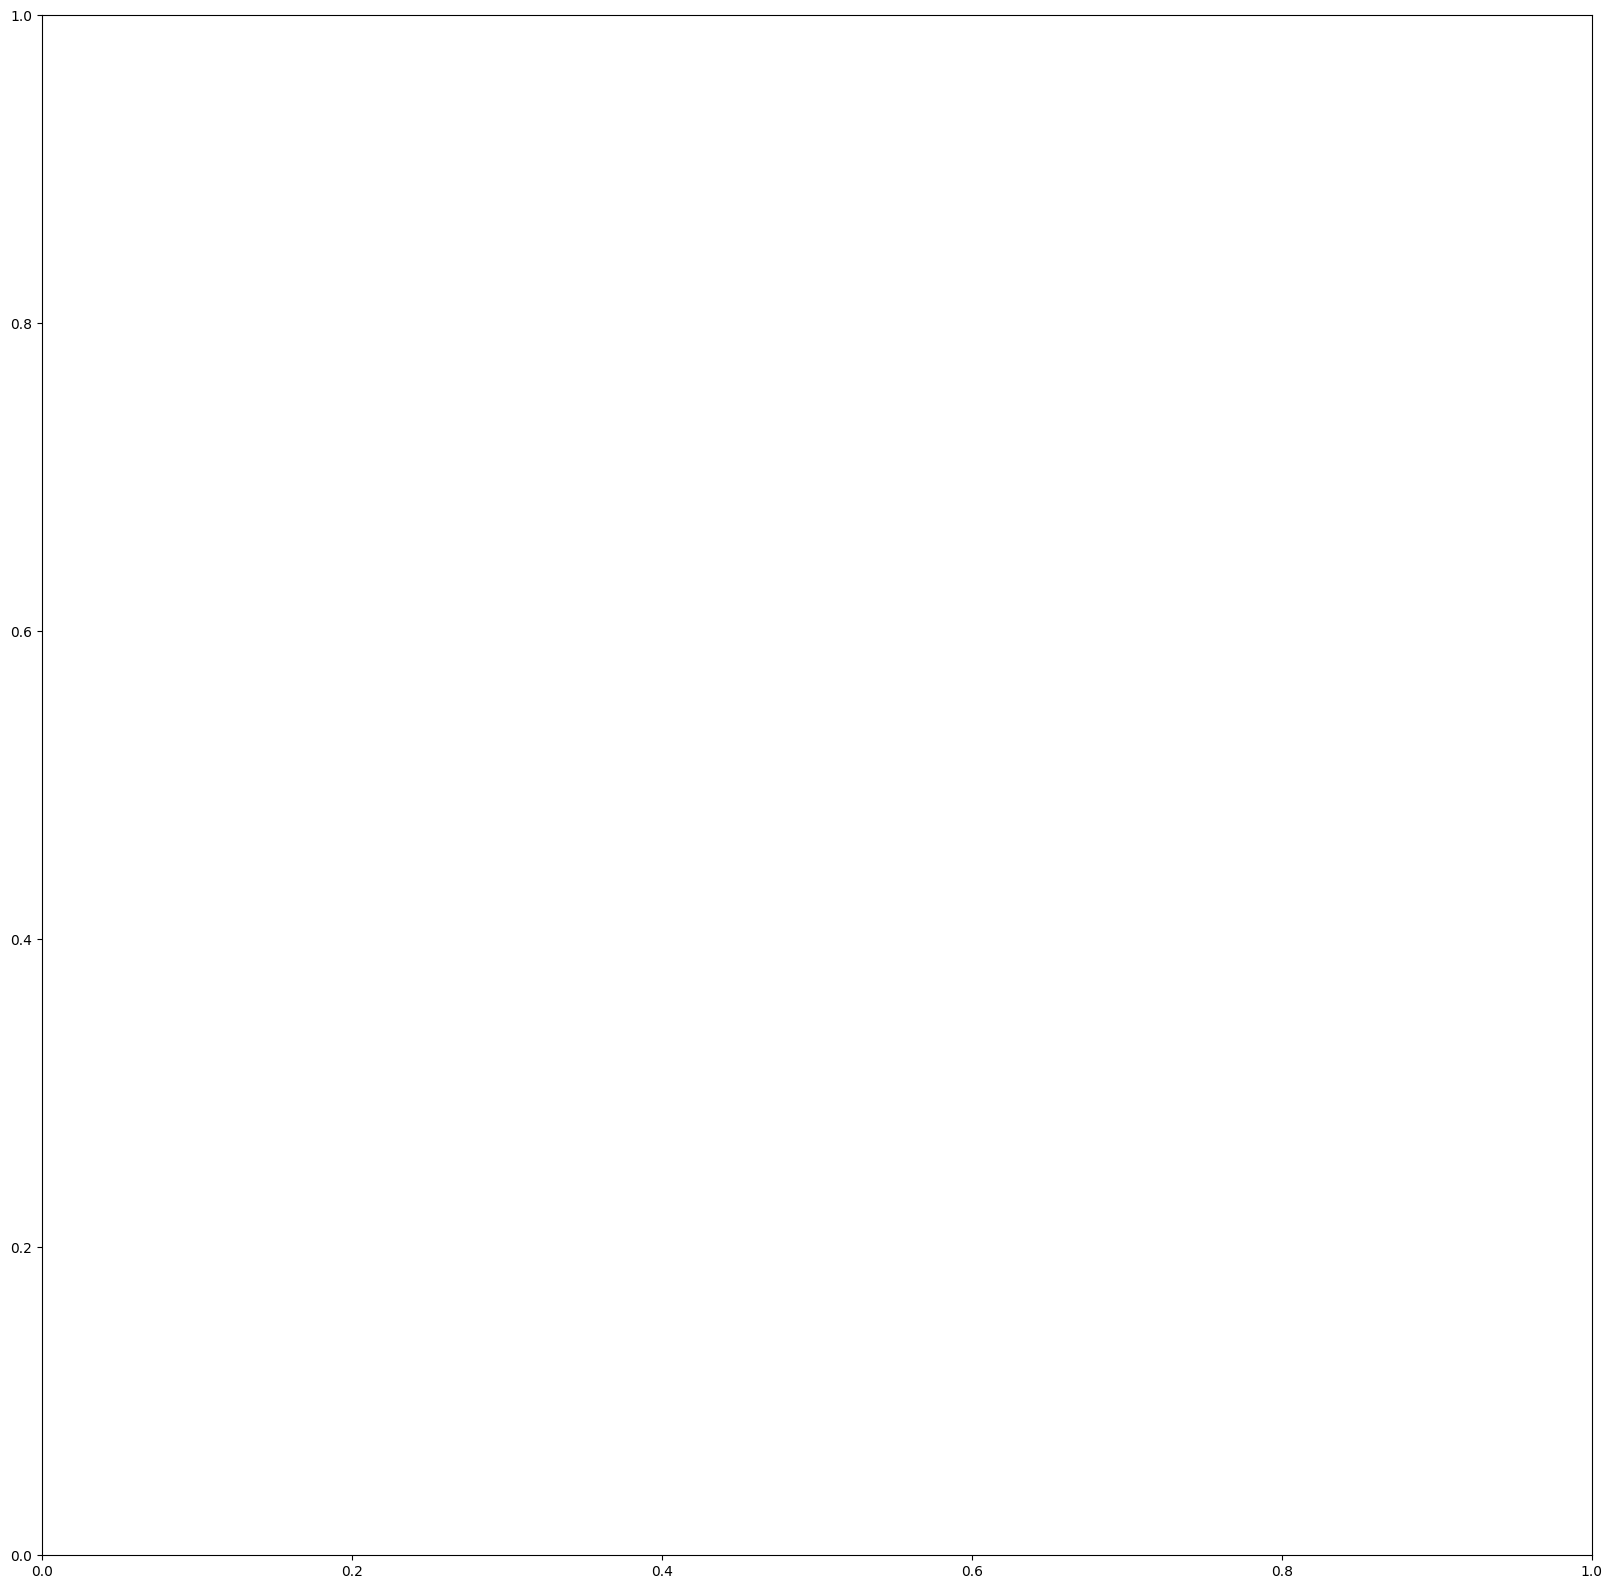

In [7]:
import os

# Create confusion matrix and visualize it
fig, ax = plt.subplots(figsize=(20, 20))  # Increased figure size
cm_array = confusion_matrix(y, y_pred)
im = ax.imshow(cm_array, cmap='Blues')
ax.set_xticks(np.arange(len(original_labels)))
ax.set_yticks(np.arange(len(original_labels)))
ax.set_xticklabels(original_labels, rotation=90, ha='right', fontsize=8)  # Adjusted label rotation and size
ax.set_yticklabels(original_labels, fontsize=8)

# Add colorbar
plt.colorbar(im, ax=ax)

# Add text annotations
for i in range(len(original_labels)):
    for j in range(len(original_labels)):
        ax.text(j, i, format(cm_array[i, j], 'd'), ha="center", va="center", color="black")

plt.tight_layout()  # Adjust layout to prevent clipping

# Save the figure
output_path = '/kaggle/working/confusion_matrix.png'
plt.savefig(output_path)

plt.show()

print(f"Confusion matrix saved to {output_path}")


In [8]:
from IPython.display import FileLink

# Provide the path to the saved confusion matrix image
output_path = '/kaggle/working/confusion_matrix.png'

# Display a link to download the image
FileLink(output_path)


/kaggle/working/confusion_matrix.png